
# Week 3: Exploring Overfitting in NLP

Welcome to this assignment! During this week you saw different ways to handle sequence-like data. You saw how some Keras' layers such as `GRU`, `Conv` and `LSTM` can be used to tackle problems in this space. Now you will put this knowledge into practice by creating a model architecture that does not overfit.

For this assignment you will be using a variation of the [Sentiment140 dataset](http://help.sentiment140.com/home), which contains 1.6 million tweets alongside their respective sentiment (0 for negative and 4 for positive).

You will also need to create the helper functions very similar to the ones you coded in previous assignments pre-process data and to tokenize sentences. However the objective of the assignment is to find a model architecture that will not overfit.

Let's get started!

In [1]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Defining some useful global variables

Next you will define some global variables that will be used throughout the assignment.

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAXLEN`: Maximum length of all sequences. Defaults to 16.


- `TRUNCATING`: Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to \"\\<OOV>\".
    
    
- `MAX_EXAMPLES`: Max number of examples to use. Defaults to 160000 (10% of the original number of examples)
    
    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9
    
    
**For now leave them unchanged but after submitting your assignment for grading you are encouraged to come back here and play with these parameters to see the impact they have in the classification process.**

In [2]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

## Explore the dataset

The dataset is provided in a csv file. 

Each row of this file contains the following values separated by commas:

- target: the polarity of the tweet (0 = negative, 4 = positive)

- ids: The id of the tweet

- date: the date of the tweet

- flag: The query. If there is no query, then this value is NO_QUERY.

- user: the user that tweeted

- text: the text of the tweet


Take a look at the first two examples:

In [3]:
SENTIMENT_CSV = "./data/training_cleaned.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



**Notice that this file does not have a header so you won't need to skip the first row when parsing the file.**

For the task at hand you will only need the information of the target and the text, which are the first and last element of each row. 

## Parsing the raw data

Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should NOT omit the first line as the file does not contain headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the label can be accessed via `row[0]` and the text via `row[5]`.
- The labels are originally encoded as strings ('0' representing negative and '4' representing positive). **You need to change this so that the labels are integers and 0 is used for representing negative, while 1 should represent positive.**


In [6]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    
    sentences = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        ### START CODE HERE
        reader = csv.reader(csvfile, delimiter=',')
        
        for row in reader:
            if row[0] == '4':
                labels.append(1)
            else:
                labels.append(0)
                
            sentences.append(row[5])
        
        ### END CODE HERE
        
    return sentences, labels

In [7]:
# Test your function
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


***Expected Output:***

```
dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]

```

You might have noticed that this dataset contains a lot of examples. In order to keep a low execution time of this assignment you will be using only 10% of the original data. The next cell does this while also randomnizing the datapoints that will be used:

In [8]:
# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



***Expected Output:***

```
There are 160000 sentences and 160000 labels after random sampling

```

## Training - Validation Split

Now you will code the `train_val_split`, which given the list of sentences, the list of labels and the proportion of data for the training set, should return the training and validation sentences and labels:

In [9]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """    
    ### START CODE HERE
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(labels) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [10]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


***Expected Output:***

```
There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.

```

## Tokenization - Sequences, truncating and padding

Now that you have sets for training and validation it is time for you to begin the tokenization process.

Begin by completing the `fit_tokenizer` function below. This function should return a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) that has been fitted to the training sentences.

In [11]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [12]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128293 words

<OOV> token included in vocabulary

index of word 'i' should be 2


***Expected Output:***

```
Vocabulary contains 128293 words

<OOV> token included in vocabulary

index of word 'i' should be 2

```

In [13]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """        
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    ### END CODE HERE
    
    return pad_trunc_sequences

In [14]:
# Test your function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


***Expected Output:***

```
Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)

```

Remember that the `pad_sequences` function returns numpy arrays, so your training and validation sequences are already in this format.

However the labels are still Python lists. Before going forward you should convert them numpy arrays as well. You can do this by running the following cell:

In [15]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Using pre-defined Embeddings

This time you will not be learning embeddings from your data but you will be using pre-trained word vectors.

In particular you will be using the 100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [16]:
# Define path to file containing the embeddings
GLOVE_FILE = './data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

Now you have access to GloVe's pre-trained word vectors. Isn't that cool?

Let's take a look at the vector for the word **dog**:

In [17]:
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

Feel free to change the `test_word` to see the vector representation of any word you can think of.

Also, notice that the dimension of each vector is 100. You can easily double check this by running the following cell:

In [18]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


## Represent the words in your vocabulary using the embeddings

Save the vector representation of each word in the vocabulary in a numpy array.

A couple of things to notice:
- If a word in your vocabulary is not present in `GLOVE_EMBEDDINGS` the representation for that word is left as a column of zeros.
- `word_index` starts counting at 1, because of this you will need to add an extra column at the left-most side of the `EMBEDDINGS_MATRIX` array. This is the reason why you add 1 to `VOCAB_SIZE` in the cell below:

In [19]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

Now you have the pre-trained embeddings ready to use!

## Define a model that does not overfit

Now you need to define a model that will handle the problem at hand while not overfitting.

A couple of things to note / hints:

- The first layer is provided so you can see how the Embedding layer is configured when using pre-trained embeddings


- You can try different combinations of layers covered in previous ungraded labs such as:
    - `Conv1D`
    - `Dropout`
    - `GlobalMaxPooling1D`    
    - `MaxPooling1D`    
    - `LSTM`    
    - `Bidirectional(LSTM)`


- The last two layers should be `Dense` layers.


- There multiple ways of solving this problem. So try an architecture that you think will not overfit.


- Try simpler architectures first to avoid long training times. Architectures that are able to solve this problem usually have around 3-4 layers (excluding the last two `Dense` ones)


- Include at least one `Dropout` layer to mitigate overfitting.

In [25]:
# GRADED FUNCTION: create_model
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model
    
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Conv1D(64, 3, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(10, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [26]:
# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4500/4500 [==============================] - 20s 4ms/step - loss: 0.5463 - accuracy: 0.7185 - val_loss: 0.5133 - val_accuracy: 0.7461
Epoch 2/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.5084 - accuracy: 0.7478 - val_loss: 0.5068 - val_accuracy: 0.7532
Epoch 3/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.4941 - accuracy: 0.7585 - val_loss: 0.4988 - val_accuracy: 0.7585
Epoch 4/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.4835 - accuracy: 0.7646 - val_loss: 0.4949 - val_accuracy: 0.7590
Epoch 5/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.4767 - accuracy: 0.7691 - val_loss: 0.5000 - val_accuracy: 0.7560
Epoch 6/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.4713 - accuracy: 0.7729 - val_loss: 0.4926 - val_accuracy: 0.7580
Epoch 7/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.4651 - accuracy: 0.7761 - val_loss: 0.4885 - val_ac

**To pass this assignment your `val_loss` (validation loss) should either be flat or decreasing.** 

Although a flat `val_loss` and a lowering `train_loss` (or just `loss`) also indicate some overfitting what you really want to avoid is having a lowering `train_loss` and an increasing `val_loss`.

With this in mind, the following three curves will be acceptable solutions:

<table><tr><td><img src='images/valid-1.png'></td><td><img src='images/valid-2.jpg'></td><td><img src='images/valid-3.jpg'></td></tr></table>

While the following would not be able to pass the grading:

<table><tr><td><img src='images/invalid-1.jpg'></td></tr></table>

Run the following cell to check your loss curves:

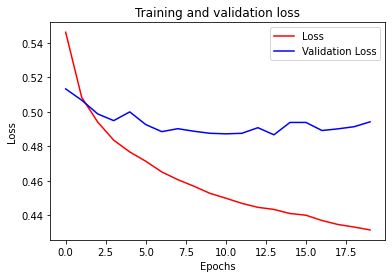

In [27]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

If you wish so, you can also check the training and validation accuracies of your model:

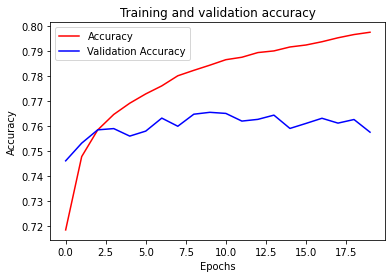

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

A more rigorous way of setting the passing threshold of this assignment is to use the slope of your `val_loss` curve.

**To pass this assignment the slope of your `val_loss` curve should be 0.0005 at maximum.**

In [29]:
# Test the slope of your val_loss curve
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00068


**If your model generated a validation loss curve that meets the criteria above, run the following cell and then submit your assignment for grading. Otherwise, try with a different architecture.**

In [30]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of classifying sentiment in text data while doing a fairly good job of not overfitting! Nice job!

**Keep it up!**